In [1]:
import random

from typing import Optional


class GamblersRuin:
    def __init__(self, p: float, i: int, N: int) -> None:
        self.p = p
        self.i = i
        self.N = N
        
        self.history = [i]
        
    @property
    def ruined(self) -> bool:
        if self.i <= 0:
            return True
        
        return False
        
    @property
    def won(self) -> bool:
        if self.i >= self.N:
            return True
        
        return False
        
    @property
    def game_over(self) -> bool:
        if self.ruined or self.won:
            return True
        
        return False
    
    @property
    def victor(self) -> Optional[int]:
        if self.won:
            return 1
        
        if self.ruined:
            return 0
            
        return None
        
    def play_round(self) -> None:
        if self.game_over:
            print("Cannot play round, the game is over.")
            return
        
        if random.uniform(0, 1) <= self.p: # Player A wins this round. 
            self.i += 1
        else:
            self.i -= 1

        # Keep track of the history of the game for analysis.
        self.history.append(self.i)
        
    def play_game(self) -> int:
        while not self.game_over:
            self.play_round()
            
        return self.victor

In [3]:
def true_probability(p: float, i: int, N: int, eps: float = 1e-12) -> None:
    """Returns the true probability that player A wins the game if they 
    have probability `p` of winning any given round, start with `i` dollars 
    of `N` total dollars in the game. 
    """
    assert 0.0 <= p <= 1.0, "`p` must be a probability between 0 and 1."
    assert 0 <= i <= N, "`i` an integer between 0 and N."
    
    q = 1.0 - p
    
    # Base cases in which player A has already won or lost.
    if i == 0: return 0.0
    if i == N: return 1.0
    
    # Another edge case and some cases with numerical instability.
    if (p <= eps):       return 0.0
    if (p >= 1.0 - eps): return 1.0
    if (p == 0.5):       return i / N

    return (1.0 - ((q / p) ** i)) / (1.0 - ((q / p) ** N))

In [4]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
def estimated_probability(p: float, i: int, N: int, n_sims: int = 1_000) -> float:
    wins = []
    for _ in range(n_sims):
        game = GamblersRuin(p = p, i = i, N = N)
        victor = game.play_game()
        wins.append(victor)
        
    return sum(wins) / len(wins)

p = 0.50
i = 5
N = 10

true_prob = true_probability(p, i, N)
print(true_prob)

est_probs = []
for n_sims in tqdm(range(1, 501)):
    probs = []
    for n_runs in range(25):
        probs.append(estimated_probability(p, i, N, n_sims))
    est_probs.append(probs)
        

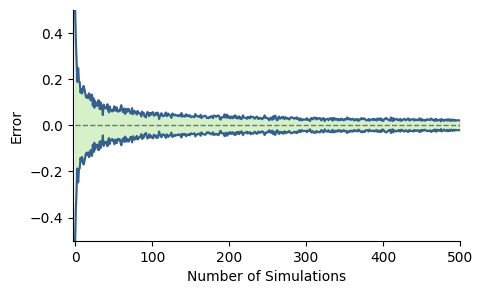

In [53]:
import seaborn as sns
import numpy as np

probs = np.array(est_probs)[:500] # n_sims, n_runs -> 1000, 25
rmse = np.sqrt(np.mean((probs - 0.5) ** 2, axis = 1))

cmap = plt.get_cmap("viridis")
plt.style.use("default")
fig, ax = plt.subplots(figsize = (5, 3))
ax.plot(rmse, color = cmap(0.3))
ax.plot(-rmse, color = cmap(0.3))
ax.plot(np.zeros((500,)), linestyle = "--", linewidth = 1.0, alpha = 0.5, color = "black")
ax.fill_between(
    np.arange(len(rmse)), -rmse, rmse, color = cmap(0.8), alpha = 0.3
)
ax.set_ylim([-0.5, 0.5])
ax.set_xlim([-3, 500])
ax.set_ylabel("Error")
ax.set_xlabel("Number of Simulations")
sns.despine()

plt.savefig("figures/error.png", dpi = 300, facecolor = "white", bbox_inches = "tight")
plt.show()

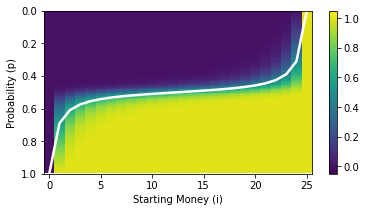

In [5]:
import matplotlib.pyplot as plt
import numpy as np

N = 25
nps = 100

image = np.zeros((nps, N+1), dtype = np.float32)
for p_index, p in enumerate(np.linspace(0, 1, nps)):
    for i in range(N+1):
        image[p_index, i] = true_probability(p, i, N)
        
plt.style.use("default")
fig, ax = plt.subplots(figsize = (6, 3))
os = 0.05
mappable = ax.imshow(image, aspect = "auto", interpolation = "none", vmin = 0 - os, vmax = 1.0 + os)
ax.plot(image.mean(axis = 0)[::-1] * 100, color = "white", linewidth = 2.5)

ax.set_ylim([100, 0])
ys = np.array([0, 20, 40, 60, 80, 100])
ax.set_yticks(ys)
ax.set_yticklabels(ys/100)
ax.set_ylabel("Probability (p)")
ax.set_xlabel("Starting Money (i)")
plt.colorbar(mappable)

plt.savefig("./figures/values.png", dpi = 300, facecolor = "white", bbox_inches = "tight")
plt.show()

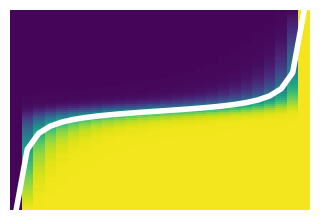

In [6]:
plt.style.use("default")
fig, ax = plt.subplots(figsize = (3, 2))
os = 0.02
ax.imshow(image, aspect = "auto", interpolation = "none", vmin = 0 - os, vmax = 1.0 + os)
ax.plot(image.mean(axis = 0)[::-1] * 100, color = "white", linewidth = 4.0)

ax.set_ylim([99, 0])
ys = np.array([0, 20, 40, 60, 80, 100])

ax.axis("off")
ax.set_xticks([])
ax.set_yticks([])
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0)

plt.savefig(
    "./figures/gr_cover.png", 
    transparent = False, 
    bbox_inches = "tight", 
    pad_inches = 0,
    dpi = 300
)
plt.show()

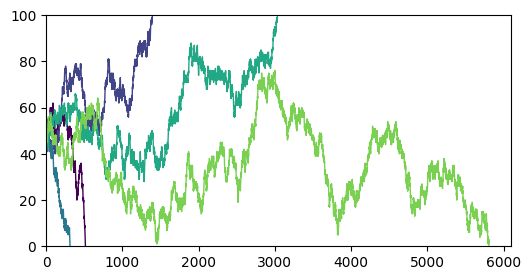

In [7]:
p = 0.5
N = 100
i = N // 2
n_sims = 5


cmap = plt.get_cmap("viridis")
plt.style.use("default")
fig, ax = plt.subplots(figsize = (6, 3))

o = 10
for r in range(n_sims):
    game = GamblersRuin(p = p, i = i, N = N)
    game.play_game()
    
    ax.plot(game.history, color = cmap(r / n_sims), linewidth = 1.0)

ax.set_ylim([0, N])
ax.set_xlim(left = 0)

plt.savefig("./figures/ex_0.png", dpi = 300, facecolor = "white", bbox_inches = "tight")
plt.show()